# Getting the most solar power for your dollar
## Model development
### Zachary Brown

I've loaded, cleaned, engineered, and split the dataset I'm using to determine how to optimize cost efficiency for a residential solar panel installation. Now I will screen a range of regression models to identify which gives the best results and refine it as best I can.

I'll start by loading in my X_train and y_train sets so that I can begin training some models.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook')
from sklearn.model_selection import train_test_split

In [2]:
print(os.getcwd())
os.chdir(r"..\data\processed")
print(os.getcwd())

C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\notebooks
C:\Users\Zachary Brown\Documents\GitHub\Solar-Panel-Capstone\data\processed


In [3]:
X_train = pd.read_csv('X_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
X_train.head()

,system_size_dc,total_installed_price,rebate_or_grant,expansion_system,multiple_phase_system,tracking,ground_mounted,third_party_owned,self_installed,azimuth_1,...,module_model_1_missing,module_model_1_not_missing,solaredge_technologies,enphase_energy,inverter_manufacturer_1_missing,inverter_manufacturer_1_other,inverter_model_1_missing,iq7,se3,inverter_model_1_other
1478082,10.460000,41856.00,3588.0,1,0,0,1,0,0,180.0,...,0,1,0,1,0,0,0,0,0,1
366544,5.250000,23625.00,1884.0,0,0,0,0,1,0,180.0,...,0,1,0,0,0,0,0,0,0,1
339150,5.985000,15000.00,0.0,0,0,0,0,0,0,61.0,...,0,1,1,0,0,0,0,0,0,1
478620,7.825194,31500.22,0.0,0,0,0,0,0,0,180.0,...,0,1,0,0,0,1,0,0,0,1
145115,4.950000,25750.00,0.0,0,0,0,0,0,0,180.0,...,0,1,1,0,0,0,0,0,0,1


In [4]:
y_train.head()

,price_per_kw
1478082,3658.508604
366544,4141.142857
339150,2506.265664
478620,4025.487482
145115,5202.020202


First I'm going to train a linear regression model to see how it performs and which features it finds important to predicting cost efficiency.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.fit_transform(y_train)

x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train['price_per_kw'], test_size=0.8)

x_tr.shape, x_te.shape, y_tr.shape, y_te.shape

((31238, 90), (124954, 90), (31238,), (124954,))

In [6]:
ols = LinearRegression()
ols.fit(x_tr, y_tr)
ols.score(x_tr, y_tr)

1.0

In [7]:
from sklearn.metrics import mean_squared_error

y_pred = ols.predict(x_te)
mean_squared_error(y_te, y_pred)

1.9143732660042053e-22

In [8]:
ols.coef_

array([-4.52128078e-13,  2.22911967e-16,  2.22044605e-16, -1.63741416e-12,
        9.45004058e-13,  8.87115055e-13,  2.28459612e-12,  5.25587793e-13,
        1.17156188e-12, -9.39467959e-16, -1.26767256e-14,  4.26986530e-14,
       -8.69934802e-13, -4.38438836e-12, -6.06048611e-13, -3.58508389e-16,
        8.92759173e-12,  1.08554413e-14, -5.61219549e-13, -9.89914447e-13,
       -2.46186874e-13, -1.12445037e-12, -1.55428272e-13,  1.65802230e-13,
       -2.39633478e-13, -8.97170521e-15,  1.00000000e+00,  4.59674612e-13,
       -7.51859478e-14,  2.62930530e-13, -3.15370849e-13,  1.95865229e-13,
        9.36628471e-15, -5.71875074e-13,  1.94823592e-13, -6.54461646e-14,
        6.81305794e-14,  2.49715656e-13, -2.20227578e-13, -2.69680814e-13,
        1.06211328e-13,  1.59839327e-13, -1.88770928e-13, -1.14312256e-13,
        1.05879118e-22,  1.02771073e-13,  3.41011184e-13, -2.84554566e-13,
        4.42765331e-13, -4.87680666e-13, -2.78895316e-13,  2.86431333e-13,
       -5.00836303e-13, -

Great! Perfect R-squared on both the train and test sets, time to pack it up and call it a capstone!

Just kidding, there are way too many coefficients here and it's probably overfit. Let's take a look at Ridge and Lasso regressions to see if they can improve upon this OLS. I'm going to use a randomized search with cross validation to identify alpha

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV
from sklearn import linear_model
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt

In [13]:
parameters = {'alpha': sp_randFloat(10000000,10000000000)}
ridge = Ridge()
ridge_reg = RandomizedSearchCV(ridge, parameters,scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                               refit='neg_root_mean_squared_error', n_iter=60, cv=5)
random_ridge = ridge_reg.fit(x_tr, y_tr)
random_ridge.best_params_

{'alpha': 182405993.1988431}

In [16]:
random_ridge_results = pd.DataFrame(random_ridge.cv_results_)
random_ridge_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_alpha', 'params', 'split0_test_neg_root_mean_squared_error',
       'split1_test_neg_root_mean_squared_error',
       'split2_test_neg_root_mean_squared_error',
       'split3_test_neg_root_mean_squared_error',
       'split4_test_neg_root_mean_squared_error',
       'mean_test_neg_root_mean_squared_error',
       'std_test_neg_root_mean_squared_error',
       'rank_test_neg_root_mean_squared_error',
       'split0_test_neg_mean_absolute_error',
       'split1_test_neg_mean_absolute_error',
       'split2_test_neg_mean_absolute_error',
       'split3_test_neg_mean_absolute_error',
       'split4_test_neg_mean_absolute_error',
       'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
       'rank_test_neg_mean_absolute_error'],
      dtype='object')

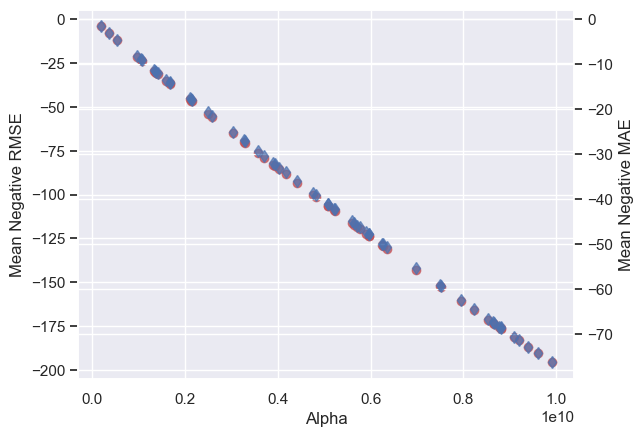

In [22]:
fig, ax = plt.subplots()
ax.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)
ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2 = ax.twinx()
ax2.plot(random_ridge_results['param_alpha'], random_ridge_results['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)
ax2.set_ylabel('Mean Negative MAE')
plt.show()

Now that I have an optimized alpha for the ridge regression I'll use it to model the test data and see how that performs.

Next I'll identify the best alpha for a lasso regression to compare that against the OLS and ridge models.

In [23]:
parameters = {'alpha': sp_randInt(10000,10000000)}
lasso = linear_model.Lasso()
rand = RandomizedSearchCV(lasso, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                          refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=0)
rand_lasso = rand.fit(x_tr, y_tr)
rand_lasso.best_params_

{'alpha': 30737}

In [24]:
rand_lasso_params = pd.DataFrame(rand_lasso.cv_results_)
rand_lasso_params.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,...,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.057677,0.008482,0.001984,0.002514,8335804,{'alpha': 8335804},-1569.008912,-4666.417023,-1480.304152,-1600.319122,...,1241.686419,51,-984.618065,-1113.617969,-1009.232710,-992.341369,-1012.731366,-1022.508296,46.730108,51
1,0.052437,0.008216,0.002944,0.003709,1494405,{'alpha': 1494405},-354.641717,-2617.313256,-326.056282,-358.143942,...,907.169615,9,-220.943702,-652.679199,-222.695495,-222.346085,-226.971218,-309.127140,171.787842,9
2,0.049854,0.001796,0.003828,0.004789,2225104,{'alpha': 2225104},-528.034345,-3897.059771,-485.475615,-533.247643,...,1350.738051,13,-328.971067,-971.807688,-331.576786,-331.054251,-337.942165,-460.270391,255.786227,13
3,0.055107,0.004603,0.006195,0.003103,5167699,{'alpha': 5167699},-1226.303100,-4496.733864,-1127.472574,-1238.407053,...,1315.832104,38,-764.007634,-1100.372239,-770.052191,-768.832469,-784.832819,-837.619471,131.560738,38
4,0.053380,0.003287,0.002077,0.002174,8232403,{'alpha': 8232403},-1569.801418,-4660.176802,-1480.035103,-1600.155339,...,1239.182785,50,-984.681387,-1113.063764,-1009.166532,-992.310531,-1012.697680,-1022.383979,46.512894,50


C:\Users\Zachary Brown\AppData\Local\Temp\ipykernel_17080\687083208.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x00000203044562B0> has a label of '_child0' which cannot be automatically added to the legend.
  ax.legend(axs, labs, loc=0)
C:\Users\Zachary Brown\AppData\Local\Temp\ipykernel_17080\687083208.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000002030448AA60> has a label of '_child0' which cannot be automatically added to the legend.
  ax.legend(axs, labs, loc=0)


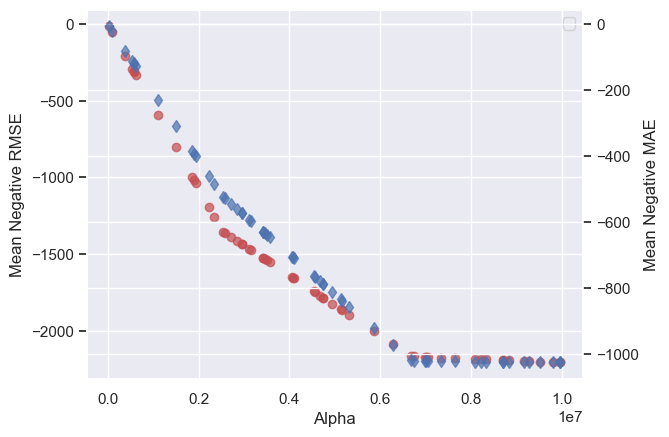

In [38]:
fig, ax = plt.subplots()

a1 = ax.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_root_mean_squared_error'], color='r',\
        marker='o', linestyle='none', alpha=0.7)

ax2 = ax.twinx()
a2 = ax2.plot(rand_lasso_params['param_alpha'], rand_lasso_params['mean_test_neg_mean_absolute_error'], color='b',\
         marker='d', linestyle='none', alpha=0.7)

axs = a1+a2
labs = [a.get_label() for a in axs]
ax.legend(axs, labs, loc=0)

ax.set_xlabel('Alpha')
ax.set_ylabel('Mean Negative RMSE')
ax2.set_ylabel('Mean Negative MAE')

plt.show()

Next I'm going to take a look at random forest and see how that does modeling this dataset.

In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

parameters = {'n_estimators': sp_randInt(10,1000),
             'max_features': sp_randFloat(0.00001, 1.0),
             'max_depth': sp_randInt(2,10),
             'min_samples_leaf': sp_randInt(1000,50000),
             }
forest = RandomForestRegressor(random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
rand_forest = forest_reg.fit(x_tr, y_tr)
rand_forest.best_params_

{'max_depth': 5,
 'max_features': 0.73253069814195,
 'min_samples_leaf': 1160,
 'n_estimators': 821}

In [28]:
rand_forest_params = pd.DataFrame(rand_forest.cv_results_)
rand_forest_params.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_neg_root_mean_squared_error,...,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,split0_test_neg_mean_absolute_error,split1_test_neg_mean_absolute_error,split2_test_neg_mean_absolute_error,split3_test_neg_mean_absolute_error,split4_test_neg_mean_absolute_error,mean_test_neg_mean_absolute_error,std_test_neg_mean_absolute_error,rank_test_neg_mean_absolute_error
0,0.303110,0.015548,0.028694,0.004295,5,0.446232,20709,251,"{'max_depth': 5, 'max_features': 0.44623174456...",-1521.652626,...,1305.635308,15,-1027.072635,-1141.968743,-1084.326285,-1059.391675,-1077.320528,-1078.015973,37.609437,18
1,0.492078,0.003504,0.041718,0.000780,4,0.533749,13108,442,"{'max_depth': 4, 'max_features': 0.53374939338...",-1521.665076,...,1305.636019,26,-1027.106084,-1141.939036,-1084.362929,-1059.448908,-1077.369065,-1078.045205,37.585659,32
2,0.542746,0.017624,0.044244,0.003147,8,0.033974,21109,483,"{'max_depth': 8, 'max_features': 0.03397417126...",-1521.671511,...,1305.632186,45,-1027.123324,-1141.961041,-1084.409101,-1059.494529,-1077.384896,-1078.074578,37.585451,52
3,4.049876,0.136410,0.054796,0.003699,4,0.725964,6194,394,"{'max_depth': 4, 'max_features': 0.72596416111...",-1123.552534,...,1406.089697,10,-655.413632,-747.541087,-691.865351,-676.208627,-678.733025,-689.952344,31.073489,11
4,0.124657,0.006733,0.012138,0.003394,7,0.606093,49397,92,"{'max_depth': 7, 'max_features': 0.60609318435...",-1521.629609,...,1305.637952,49,-1027.010823,-1141.917015,-1084.464917,-1059.719788,-1077.435775,-1078.109664,37.580581,59


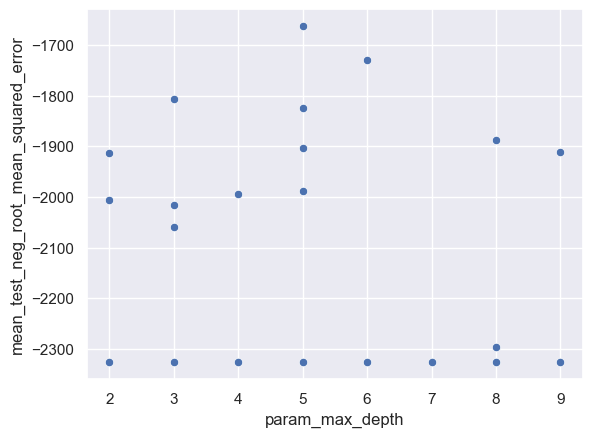

In [29]:
sns.scatterplot(data=rand_forest_params, x='param_max_depth', y='mean_test_neg_root_mean_squared_error')
plt.show()

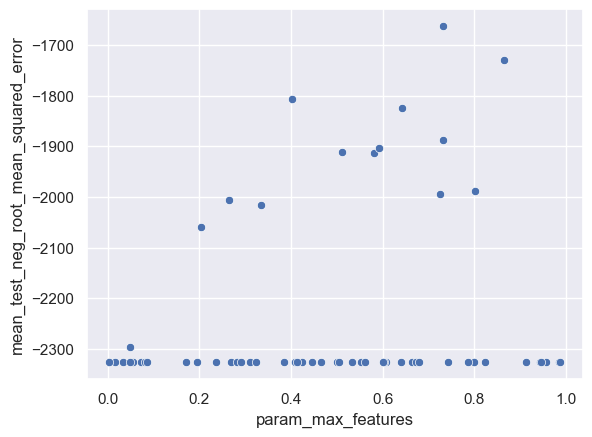

In [30]:
sns.scatterplot(data=rand_forest_params, x='param_max_features', y='mean_test_neg_root_mean_squared_error')
plt.show()

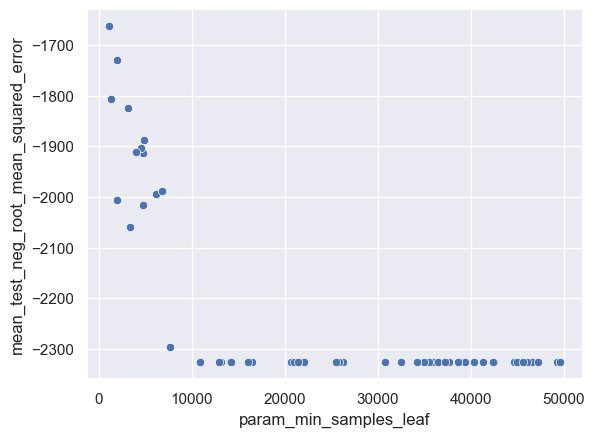

In [31]:
sns.scatterplot(data=rand_forest_params, x='param_min_samples_leaf', y='mean_test_neg_root_mean_squared_error')
plt.show()

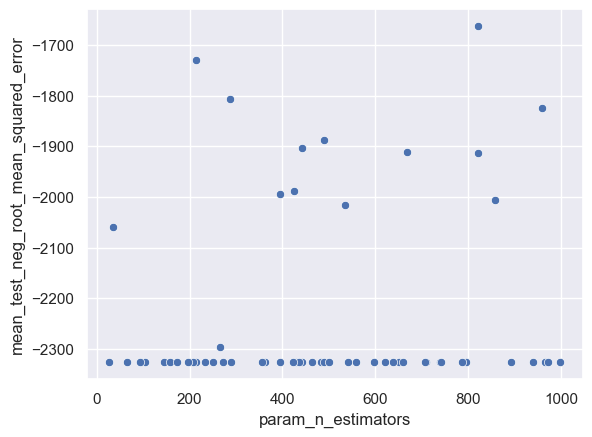

In [32]:
sns.scatterplot(data=rand_forest_params, x='param_n_estimators', y='mean_test_neg_root_mean_squared_error')
plt.show()

In [ ]:
parameters = {
             'min_samples_leaf': sp_randInt(50,10000)
             }
forest = RandomForestRegressor(n_estimators=821, max_features=0.73253069814195, max_depth=5, random_state=12)
forest_reg = RandomizedSearchCV(forest, parameters, scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],\
                                refit='neg_root_mean_squared_error', n_iter=60, cv=5, random_state=12)
rand_forest = forest_reg.fit(x_tr, y_tr)
rand_forest.best_params_

In [ ]:
opt_forest = RandomForestRegressor(n_estimators=821, max_features=0.73253069814195, min_samples_leaf=, max_depth=5, random_state=12)
opt_forest.fit(x_tr, y_tr)
y_pred = ols.predict(x_te)
mean_squared_error(y_te, y_pred)